<a href="https://colab.research.google.com/github/Chewye/datatalks/blob/main/DataTalks_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
data_filepath = "/content/gdrive/MyDrive/data/AER_credit_card_data.csv"
data = pd.read_csv(data_filepath)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [5]:
data['card'] = data['card'].replace(to_replace=['yes', 'no'], value=[1, 0])
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
y_train = df_train['card']
y_val = df_val['card']
y_test = df_test['card']


In [8]:
col_nums = ['reports', 'dependents', 'active', 'share']

In [9]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    t = y_pred.mean() / 2
    for t in range(len(y_val)):
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((tp, fp, fn, tn))

    columns = ['tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [10]:
for col in col_nums:
  tpr_fpr = tpr_fpr_dataframe(y_train, df_train[col])
  score = metrics.auc(tpr_fpr['fpr'], tpr_fpr['tpr'])
  if score < 0.5:
    score = 1 - score
  print(f"{col}: {score}")

reports: 0.7166629860689376
dependents: 0.5327757227773791
active: 0.6043173411362006
share: 0.5


**Question 1:** reports

In [11]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [12]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months",
            "majorcards", "active", "owner", "selfemp"]

train_dict = df_train[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)


In [13]:
val_dict = df_val[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(val_dict)

X_val = dv.transform(val_dict)


In [14]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:
predict_val = model.predict_proba(X_val)[:, 1]

In [16]:
round(metrics.roc_auc_score(y_val, predict_val), 3)

0.995

**Question 2** What's the AUC of this model on the validation dataset? (round to 3 digits) - 0,995

In [17]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (predict_val >= t)
    predict_negative = (predict_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    rec = tp / (tp + fn)
    prec = tp / (tp + fp)

    f1 = 2 * prec * rec / (prec + rec)
    
    scores.append((t, tp, fp, fn, tn, rec, prec, f1))

In [18]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'rec', 'prec', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

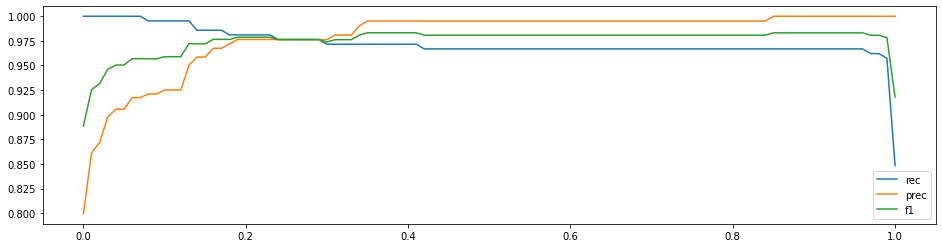

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(df_scores.threshold, df_scores['rec'], label='rec')
plt.plot(df_scores.threshold, df_scores['prec'], label='prec')
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()

In [20]:
for i in [0.1, 0.3, 0.6, 0.8]:
  print(f"{df_scores[df_scores['threshold'] == i][['threshold', 'prec', 'rec']]}")

    threshold     prec       rec
10        0.1  0.92511  0.995261
    threshold     prec       rec
30        0.3  0.97619  0.971564
    threshold      prec       rec
60        0.6  0.995122  0.966825
    threshold      prec       rec
80        0.8  0.995122  0.966825


**Question 3** At which threshold precision and recall curves intersect? - 0.3

In [21]:
for i in [0.1, 0.4, 0.6, 0.7]:
  print(f"{i}: {df_scores[df_scores['threshold'] == i]['f1']}")

0.1: 10    0.958904
Name: f1, dtype: float64
0.4: 40    0.983213
Name: f1, dtype: float64
0.6: 60    0.980769
Name: f1, dtype: float64
0.7: Series([], Name: f1, dtype: float64)


**Question 4**  At which threshold F1 is maximal? - 0,4

In [22]:
df_scores.iloc[df_scores['f1'].idxmax()]['threshold']

0.35000000000000003

**Question 4** At which threshold F1 is maximal? - 0,4

In [23]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=1)

In [26]:
def cv_train(C=1):
  scores = []
  for train_idx, val_idx in cv.split(df_full_train):
    train = df_full_train.iloc[train_idx]
    val = df_full_train.iloc[val_idx]

    y_train = train.card.values
    y_val = val.card.values

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

    full_dict = train[features].to_dict(orient='records')
    dv.fit(full_dict)
    X_full = dv.transform(full_dict)

    model.fit(X_full, y_train)

    val_dict = val[features].to_dict(orient='records')
    X = dv.transform(val_dict)
    y_pred_cv = model.predict_proba(X)[:, 1]
 
    auc = metrics.roc_auc_score(y_val, y_pred_cv)
    scores.append(auc)
  return scores

In [27]:
round(np.std(cv_train()), 3)

0.003

**Question 5** How large is standard devidation of the AUC scores across different folds? - 0.003

In [28]:
C = [0.01, 0.1, 1, 10]

In [29]:
for i in C:  
  print(f"{i}: {np.mean(cv_train(C=i))}")

0.01: 0.9918810292344007
0.1: 0.9950557137157224
1: 0.9964498276814243
10: 0.9963886109436032


**Question 6** Which C leads to the best mean score? - 1